## This File uses full text of articles to run grid search on LDA model parameters 
Code can be used to generate plots A4 and A5

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import pandas as pd
import numpy as np

#------------------
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
#import gensim.corpora as corpora
from gensim.utils import simple_preprocess

import spacy

# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis

In [17]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

### Uploading data

Note: now each article has it's own id

In [14]:
popular=pd.read_csv('../../Data/Most_popular_id_2019_2021.csv')
all_articles=pd.read_csv('../../Data/articles_data.csv')
text=pd.read_csv('../../Data/articles_text.csv')
all_articles=pd.merge(all_articles, text[['id', 'full_text']], how='left', on='id', validate='one_to_one')
fb_em=list(set(list(popular.id_emailed)+list(popular.id_facebook)))
articles=all_articles[all_articles.id.isin(fb_em)].reset_index(drop=True)

#Remove articles without text 
print('articles removed:', articles[articles.full_text.isna()].shape[0])
articles=articles[~articles.full_text.isna()]
articles.shape

(13688, 30)

#### Preparing data

In [16]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
data = articles.full_text.str.lower().values.tolist()
data_words = list(sent_to_words(data))

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
bigram = gensim.models.Phrases(data_words, min_count=15, threshold=1000)
trigram = gensim.models.Phrases(bigram[data_words], threshold=1000)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#------
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words_bigrams)
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#### Full text models

In [26]:
#Dictionary
dictionary = corpora.Dictionary(data_lemmatized)
dictionary.filter_extremes(no_below=15, no_above=0.5)
 
# Create Corpus
texts = data_lemmatized
corpus = [dictionary.doc2bow(text) for text in texts]

### Coherence

In [69]:
for num_topics in range(25, 50, 5):
    print('num_topics:', num_topics)
    for i in range(5):
        model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=10, 
                                         per_word_topics=True, ) 

        #model.save("../Data/Models/Number_of_topics/full/LDA_"+str(num_topics)+"_topics_"+str(i))

####  Coherence score

In [70]:
#coherences=[[],[],[],[],[]]
for num_topics in range(25, 50, 5):
    print('num_topics:', num_topics)
    for i in range(5):
        print(i)
        model = gensim.models.ldamodel.LdaModel.load("../Data/Models/Number_of_topics/full/LDA_"+
                                                     str(num_topics)+"_topics_"+str(i))
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherences[i].append(coherencemodel.get_coherence())

### Number of topics with default

In [28]:
def compute_values(dictionary, corpus, texts, limit, start=20, step=10):
    
    df_coherence=pd.DataFrame(columns=['num_topics', 'coherence_score', 'perplexity_score'])
    df_coherence.to_csv("../../Data/number_of_topics.csv", index=False)

    coherence_values = []
    perplexity_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        print('num_topics:', num_topics)
        model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=10, #chunksize=500,
                                         per_word_topics=True) 
        #model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(model.log_perplexity(corpus))
        
        df_coherence=pd.DataFrame([[num_topics, coherence_values[-1], perplexity_values[-1]]])
        df_coherence.to_csv("../../Data/number_of_topics.csv", index=False, mode='a', header=False)
        

    return model_list, coherence_values, perplexity_values


In [ ]:
import time
start_time = time.time()
model_list, coherence_values, perplexity_values = compute_values(dictionary=dictionary, corpus=corpus,
                                                        texts=data_lemmatized, start=20, limit=25, step=10)
print("--- %s seconds ---" % (time.time() - start_time))

num_topics: 20


### Use coherence_values from above to make plot A4

# Grid search

In [31]:
chunksize_lst=[64, 256, 1024]
offset_lst=[1,4,16]
eval_every_lst=[1, 16, 256]
decay_lst=[0.5, 0.7]
num_topics_lst=[30, 35, 40, 45]

import itertools
params=list(itertools.product(chunksize_lst, offset_lst, eval_every_lst, decay_lst, num_topics_lst))


def get_coherence_params(chunksize, offset, eval_every, num_topics=40, passes=10, decay=0.5, save=False):
    model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, 
                                       per_word_topics=True, offset=offset, decay=decay, eval_every=eval_every, 
                                       chunksize=chunksize)

    if save:
        model.save("../../Data/Models/Number_of_topics/full/LDA_"+str(chunksize)+'_'+str(offset)+'_'+str(eval_every))
        
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherencemodel.get_coherence()
    
len(params)

216

#### search

In [ ]:
import time
df_results=pd.DataFrame(columns=['num_topics', 'decay', 'chunksize', 'offset', 'eval_every', 'coherence_score'])
#df_results.to_csv("big_grid_search.csv", index=False)
results=[] 

for step in range(len(params)):
    print('step', step+1, 'out of', len(params))
    start = time.time()
    chunksize, offset, eval_every, decay, num_topics=params[step]
    coherence_score=get_coherence_params(chunksize, offset, eval_every, num_topics=num_topics, decay=decay)
    results.append([num_topics, decay, chunksize, offset, eval_every, coherence_score])
    end = time.time()
    print(end - start)
    
    if (step+1)%10==0:
        df_results=pd.DataFrame(results, columns=['num_topics', 'decay', 'chunksize', 'offset', 'eval_every', 'coherence_score'])
        #df_results.to_csv("big_grid_search.csv", index=False, mode='a', header=False)
        results=[]

#### results

In [25]:
df_results=pd.read_csv("../../Data/big_grid_search.csv")
df_results[df_results.coherence_score>0.52]
df_results.groupby('chunksize').max()[['coherence_score']]

,coherence_score
chunksize,
64,0.533511
256,0.489751
1024,0.480556


In [10]:
df_results.columns.to_list()[0:-1]

['decay', 'chunksize', 'offset', 'eval_every']

## Figure A5

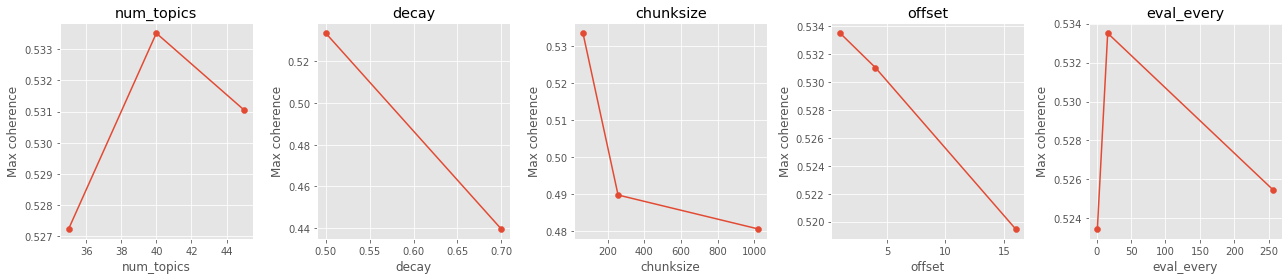

In [44]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

fig, axs = plt.subplots(figsize=(18,4),nrows=1, ncols=5) 
titles=df_results.columns.to_list()[0:-1]
for i in range(5):
    col=df_results.columns.to_list()[0:-1][i]
    #a=intersections[i]
    df_results.groupby(col).max().coherence_score.plot(ax=axs[i])
    axs[i].scatter(df_results.groupby(col).max().coherence_score.index, df_results.groupby(col).max().coherence_score)
    #sns.histplot(a, discrete = True, stat="density", ax=axs[i//2,i%2])
    axs[i].set_ylabel('Max coherence')
    axs[i].set_title(titles[i])
plt.tight_layout()
plt.show()

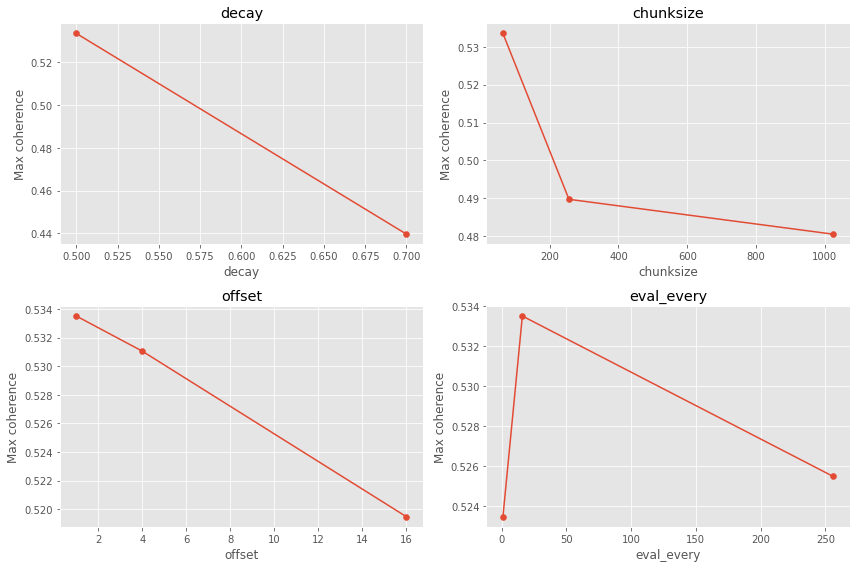

In [42]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

fig, axs = plt.subplots(figsize=(12,8),nrows=2, ncols=2) 
titles=df_results.columns.to_list()[1:-1]
for i in range(4):
    col=df_results.columns.to_list()[1:-1][i]
    #a=intersections[i]
    df_results.groupby(col).max().coherence_score.plot(ax=axs[i//2,i%2])
    axs[i//2,i%2].scatter(df_results.groupby(col).max().coherence_score.index, df_results.groupby(col).max().coherence_score)
    #sns.histplot(a, discrete = True, stat="density", ax=axs[i//2,i%2])
    axs[i//2,i%2].set_ylabel('Max coherence')
    axs[i//2,i%2].set_title(titles[i])
plt.tight_layout()
plt.show()